In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

# Getting Started

In this example, we generate some fake spectra plagued by bright point sources. We then mask those sources and generate spectra which have been corrected for the mode coupling induced by our mask.

We start by importing our libraries.

In [2]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

import nawrapper as nw
import nawrapper.maptools as maptools

Let's generate a random map to try doing analysis on. We'll use the spectrum $C_{\ell} = \ell^{-2.5}$.
We'll use a 2 arcminute pixel to make this fast.

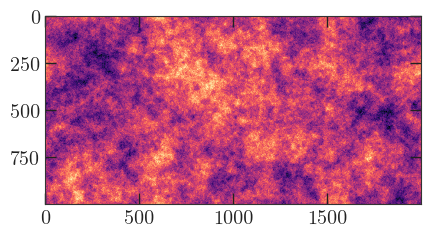

In [3]:
shape,wcs = enmap.geometry(shape=(1000,2000),
                           res=np.deg2rad(2/60.),pos=(0,0))
ells = np.arange(0,2000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

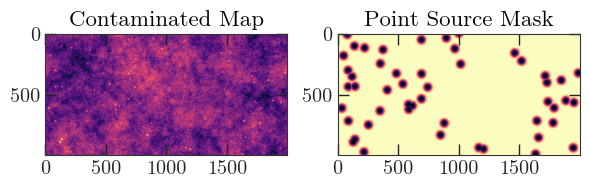

In [5]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0
point_source_map = 1 - maptools.apod_C2(mask, 0.5)
imap += point_source_map
mask = maptools.apod_C2(mask, 2)

fig, axes = plt.subplots(1, 2, figsize=(6,12))
axes[0].imshow(imap)
axes[1].imshow(mask)
axes[0].set_title('Contaminated Map')
axes[1].set_title('Point Source Mask')
plt.tight_layout()

For additional realism we generate noise power spectra to add to our “splits”.

Text(0.5, 0, 'Multipole $\\ell$')

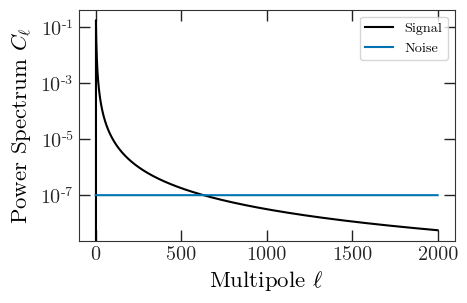

In [6]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-7

plt.plot(ps, "-", label="Signal")
plt.plot(nl, "-", label="Noise")
plt.yscale('log')
plt.legend()
plt.ylabel(r'Power Spectrum $C_{\ell}$')
plt.xlabel(r'Multipole $\ell$')

In [7]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example, we won’t include a beam. Now we set up the `namap_car` objects, using as input our our original random realization summed with the noise realizations.

# The Power Spectrum Part

In [8]:
namap_1 = nw.namap_car(maps=(imap + noise_map_1, None, None), masks=mask)
namap_2 = nw.namap_car(maps=(imap + noise_map_2, None, None), masks=mask)

Assuming the same mask for both I and QU.
Creating a car namap. temperature: True, polarization: False
temperature beam not specified, setting temperature beam to 1.
Applying a k-space filter (kx=0, ky=0, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Creating a car namap. temperature: True, polarization: False
temperature beam not specified, setting temperature beam to 1.
Applying a k-space filter (kx=0, ky=0, apo=40), unpixwin: True
Computing spherical harmonics.



Now let's compute the mode coupling matrix. First we need to set up a binning object. The easiest way to do this is `create_binning` from nawrapper, which takes a function for the weights and either a list of bin widths for `widths=` or an integer (in which case all bins will have the same width).

You can load this from file (see `nw.read_bins`))

In [9]:
# 40 bins of width 50 and 50 bins of width 100
# lmax cuts off the end bins, so nothing over 1000 is included
bins = nw.create_binning(lmax=2000, lmin=2, 
                         widths=[50]*40 + [100]*50, 
                         weight_function=(lambda ell : ell**2))

We associate a mode-coupling object with a directory. Here, we specify a relative path. The mode-coupling object will write the matrices to disk when it is done computing. Future runs will look at the specified path for precomputed mode-coupling matrices, and read them in if they exist. To recompute matrices, specify the argument `overwrite=True`.

In [10]:
mc = nw.mode_coupling(namap_1, namap_2, bins,
                      mcm_dir='./quickstart_mcm/', overwrite=True)

Computing new mode-coupling matrices.
Saving mode-coupling matrices to ./quickstart_mcm/


Finally, we can compute some spectra!

In [11]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb.keys())

dict_keys(['TT', 'ell'])


The result `Cb` is a dictionary with two keys, the multipole `ell` and the temperature power spectrum `TT`. Let’s plot it!

Text(0, 0.5, '$C_{\\ell}$')

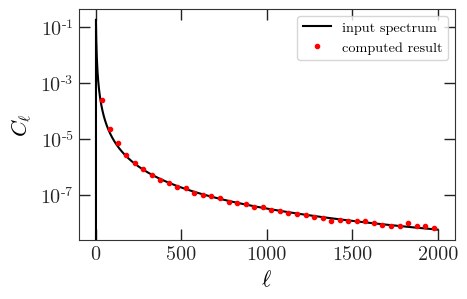

In [12]:
plt.plot(ps, 'k-', label='input spectrum')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed result')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$\ell$'); plt.ylabel(r'$C_{\ell}$')